## Предсказание длительности поездки такси в Нью-Йорке
### Постановка задачи

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


### Знакомство с данными, базовый анализ и расширение данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

import xgboost as xgb

In [2]:
# Параметры для графиков
mpl.rc('figure', facecolor='#006064', titlesize=10)
mpl.rc('text', color='#FFB473')
mpl.rc('axes', facecolor='#F0F9FA', edgecolor='white', labelcolor='#FFB473', labelsize='small', titlesize=9, titlecolor='#F0F9FA')
mpl.rc('axes.spines')
mpl.rc('patch', edgecolor='#F0F9FA', linewidth=0.3)
mpl.rc('xtick', color='white', labelsize= 7, labelcolor='#FFB473')
mpl.rc('ytick', color='white', labelsize= 7, labelcolor='#FFB473')
mpl.rc('lines', linewidth=0.6)
mpl.rc('legend', fontsize=7, edgecolor='white', labelcolor='#006064', title_fontsize=9, framealpha=0.3)

cmap = ['#39E444', '#466FD5', '#FF9840', '#34C6CD']
cmap_lines = ['#00C90D', '#123EAB', '#01939A', '#FF7600']

Чтение данных:

In [3]:
taxi_data = pd.read_csv("Data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


В датасете 1458644 записей и 11 признаков

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


##### 2.1. Определение временных рамок данных.

In [5]:
# преобразуем признак 'pickup_datetime' в формат datetime
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# Выведем данные о временном периоде данных
print("Начальная дата выборки:", taxi_data['pickup_datetime'].min())
print("Конечная дата  выборки:", taxi_data['pickup_datetime'].max())
print("Период:", taxi_data['pickup_datetime'].dt.to_period('D').max() - taxi_data['pickup_datetime'].dt.to_period('D').min())

Начальная дата выборки: 2016-01-01 00:00:17
Конечная дата  выборки: 2016-06-30 23:59:39
Период: <181 * Days>


##### 2.2 Определение пропусков данных. 

In [6]:
# Выводим информацию о датасете
print('Имеются ли пропуски в данных:', taxi_data.isnull().any().any())
print('-'*40)
print(taxi_data.info())

Имеются ли пропуски в данных: False
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(

Пропусков в данных нет

##### 2.3 Статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [7]:
# Число уникальных таксопарков
print('Число таксопарков:', taxi_data['vendor_id'].value_counts().count())
print('-'*40)
# Максимальное количество пассажиров
print('Максимальное число пассажиров в поездке:', taxi_data['passenger_count'].max())
print('-'*40)
# Средняя и медианная длительность поездки
print(f'Средняя  длительность  поездки: {taxi_data['trip_duration'].mean():.0f} сек')
print(f'Медианная длительность поездки: {taxi_data['trip_duration'].median():.0f} сек')
print('-'*40)
# Минимум и максимум длительности поездки
print(f'Минимальная  длительность поездки: {taxi_data['trip_duration'].min()} сек')
print(f'Максимальная длительность поездки: {taxi_data['trip_duration'].max()} сек')

Число таксопарков: 2
----------------------------------------
Максимальное число пассажиров в поездке: 9
----------------------------------------
Средняя  длительность  поездки: 959 сек
Медианная длительность поездки: 662 сек
----------------------------------------
Минимальная  длительность поездки: 1 сек
Максимальная длительность поездки: 3526282 сек


##### 2.4 Формирование новых временных признаков
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [8]:
# Процедура создания признаков дня, дня недели и часа
def add_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.weekday
    return df

taxi_data = add_datetime_features(taxi_data)
# Число поездок в субботу
print(f'Число поездок в субботу: {taxi_data[taxi_data['pickup_day_of_week'] == 5]['pickup_day_of_week'].count()}')
print('-'*40)
# Среднее число поездок в день
print(f'Среднее число поездок в день: {taxi_data['pickup_date'].value_counts().mean():.0f}')

Число поездок в субботу: 220868
----------------------------------------
Среднее число поездок в день: 8015


##### 2.5 Добавление данных о праздничных днях
* Данные о праздниках берем из файла 'holiday_data.csv.
* Добавляем бинарный признак pickup_holiday -  начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 
* Чему равна медианная длительность поездки на такси в праздничные дни? Ответ в секундах, округленный до целого.

In [9]:
# Процедура создания индикатора праздничных дней
def add_holiday_features(df: pd.DataFrame, holiday_df: pd.DataFrame) -> pd.DataFrame:
    holiday_df['date'] = pd.to_datetime(holiday_df['date']).dt.date
    df = pd.merge(df, holiday_df['date'], how='left', left_on='pickup_date', right_on='date')
    df['pickup_holiday'] = df['date'].isna().apply(lambda x: 0 if x == True else 1)
    df = df.drop('date', axis=1)
    return df
    
holiday_data = pd.read_csv('Data/holiday_data.csv', sep=';') # Чтение таблицы праздников
taxi_data = add_holiday_features(taxi_data, holiday_data) # создание индикатора праздничных дней

print(f'Медианная длительность поездки в праздничные дни: {taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median()}')

Медианная длительность поездки в праздничные дни: 585.0


##### 2.6 Добавление географических данных 
* Данные о географии берем из файла osrm_data_train.csv.
* В основной датасет добавляем  3 столбца:
    * total_distance;
    * total_travel_time;
    * number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [10]:
osrm_data = pd.read_csv('Data/osrm_data_train.csv')

# ваш код здесь
def add_osrm_features(df: pd.DataFrame, osrm_df: pd.DataFrame) -> pd.DataFrame:
    orsm_data_part = osrm_df[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    res_df = pd.merge(df, orsm_data_part, 
                        how='left',
                        left_on = 'id', right_on = 'id'
                        )
    return res_df

taxi_data = add_osrm_features(taxi_data, osrm_data)

print('Разница между медианной длительностью поездки по базе такси и по данным osrm: ', end='')
print(f'{(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()):.0f}')
print('-'*40)
print(f'Cтроки с пропусками в присоединенных данных: {taxi_data[taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isnull().any(axis=1)]['id'].count()}')

Разница между медианной длительностью поездки по базе такси и по данным osrm: 372
----------------------------------------
Cтроки с пропусками в присоединенных данных: 1


##### 2.7 Добавление признаков гаверсинуса и расстояния
Добавить два новых признака:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [11]:
# ваш код здесь
def add_geographical_features(df: pd.DataFrame) -> pd.DataFrame:
    
    def get_haversine_distance(lat1, lng1, lat2, lng2):
        # переводим углы в радианы
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        # радиус земли в километрах
        EARTH_RADIUS = 6371 
        # считаем кратчайшее расстояние h по формуле Хаверсина
        lat_delta = lat2 - lat1
        lng_delta = lng2 - lng1
        d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
        h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
        return h

    def get_angle_direction(lat1, lng1, lat2, lng2):
        # переводим углы в радианы
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        # считаем угол направления движения alpha по формуле угла пеленга
        lng_delta_rad = lng2 - lng1
        y = np.sin(lng_delta_rad) * np.cos(lat2)
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
        alpha = np.degrees(np.arctan2(y, x))
        return alpha

    df['haversine_distance'] = df.apply(lambda row: get_haversine_distance(
                                        row['pickup_latitude'], 
                                        row['pickup_longitude'], 
                                        row['dropoff_latitude'], 
                                        row['dropoff_longitude']), 
                                        axis=1)
    
    df['direction'] = df.apply(lambda row: get_angle_direction(
                               row['pickup_latitude'], 
                               row['pickup_longitude'], 
                               row['dropoff_latitude'], 
                               row['dropoff_longitude']), axis=1)
    return df

taxi_data = add_geographical_features(taxi_data)
print(f'Медианное расстояние гаверсинуса: {taxi_data['haversine_distance'].median():.2f}')

Медианное расстояние гаверсинуса: 2.09


##### 2.8. Кластеризация поездок
Добавление столбца geo_cluster - географический кластер, к которому относится поездка методом KMeans.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [12]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# Процедура создания географических кластеров
def add_cluster_features(df: pd.DataFrame, kmeans) -> pd.DataFrame:
    
    coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                        df[['dropoff_latitude', 'dropoff_longitude']]))
    
    clusters_predict = kmeans.predict(coords)
    df['geo_cluster'] = clusters_predict
    return df

taxi_data = add_cluster_features(taxi_data, kmeans)
taxi_data['geo_cluster'].value_counts()

geo_cluster
0    595850
6    405045
9    322999
7     45791
3     40671
2     32769
8     15510
4         4
5         3
1         2
Name: count, dtype: int64

##### 2.9. Добавление признаков погодных условий
Из файла weather_data.csv добавить в основной датасет данные:

* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [13]:
# Процедура добавления столбцов с погодными условиями
def add_weather_features(df: pd.DataFrame, weather_df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = df['pickup_datetime'].dt.to_period('h')
    weather_df['date'] = pd.to_datetime(weather_data['time']).dt.to_period('h')
    
    df = pd.merge(df, weather_data,
                      how='left', 
                      on='date'
                      )
    df = df.drop(columns=['date', 'time'])
    return df

# Загружаем данные о погодных условиях
weather_data = pd.read_csv('Data/weather_data.csv', 
                           usecols = ['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']
                           )
# Добавляем столбцы в основной датасет
taxi_data = add_weather_features(taxi_data, weather_data)

print(f'Число поездок, совершенных в снежную погоду: {taxi_data['events'].value_counts().loc['Snow']}')
#print(f'Процент пропусков в поле evenst: {(taxi_data['events'].isnull().value_counts(normalize=True) * 100).loc[True]:.2f} %')

Число поездок, совершенных в снежную погоду: 13126


In [14]:
taxi_data['events'].isnull().value_counts(normalize=True)

events
True     0.951032
False    0.048968
Name: proportion, dtype: float64

##### 2.10. Заполнение пропусков
* Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполнить медианными значениями.
* Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

* Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [15]:
# Процедура заполнения пропусков
def fill_null_weather_data(taxi_data):
    median_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    # Заполнение медианными значениями по дате
    for column in median_columns:
        taxi_data[column] = taxi_data[column].fillna(taxi_data.groupby('pickup_date')[column].transform('median'))
    # Заполнение пропусков признака 'event'
    taxi_data['events'] = taxi_data['events'].fillna('None')
    # Заполнение пропусков 'total_distance', 'total_travel_time' и 'number_of_steps'
    taxi_data[['total_distance', 
               'total_travel_time', 
               'number_of_steps']] = taxi_data[['total_distance', 
                                                'total_travel_time', 
                                                'number_of_steps']].fillna(
        taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].median())
    
    return taxi_data

taxi_data = fill_null_weather_data(taxi_data)
print(f'Медианное значение температуры: {taxi_data['temperature'].median():.1f}')
    

Медианное значение температуры: 11.1


##### 2.11. Выбросы по длительности поездки

Найдем поездки, длительность которых превышает 24 часа и удалим их из набора данных.
* Выбросами будут считаться поездки, длительность которых превышает 24 часа.
* Выбросами будут считаться поездки, средняя скорость которых превышает 300 км/ч.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

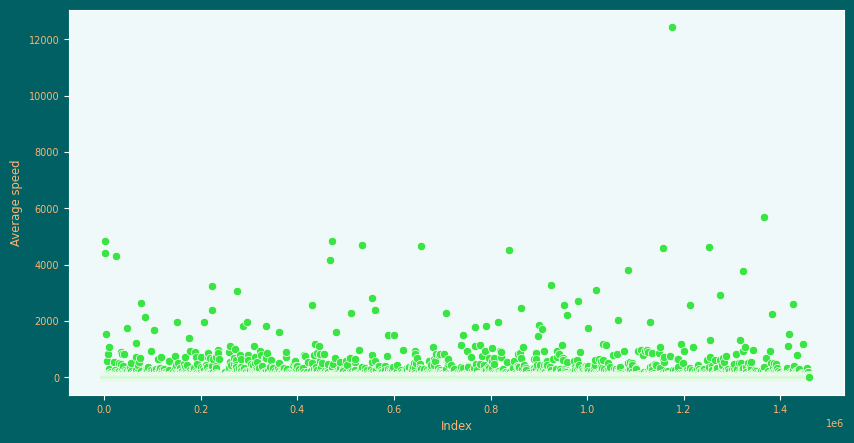

In [16]:
# Диаграмма средней скорости (км/ч)
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, color=cmap[0], ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

In [17]:
# Удаление поездок, длительностью более 24 часов
print(f'Число поездок длительностью более 24 часов: {taxi_data[(taxi_data['trip_duration'] / 3600) > 24]['id'].count()}')
print('-'*40)
taxi_data = taxi_data.drop(taxi_data[(taxi_data['trip_duration'] / 3600) > 24].index)

# Удаление поездок со средней скоростью, превышающей 300 км/ч
print(f'Число поездок со средней скоростью более 300 км/ч: {taxi_data[(taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6) > 300]['id'].count()}')
taxi_data = taxi_data.drop(taxi_data[(taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6) > 300].index)

Число поездок длительностью более 24 часов: 4
----------------------------------------
Число поездок со средней скоростью более 300 км/ч: 407


### Разведывательный анализ данных (EDA)

In [18]:
# Логарифмируем целевой признак
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

#### Гистограмма и коробчатая диаграмма длительности поездок в логарифмическом масштабе. 
Проверка целевого признака на нормальное распределение

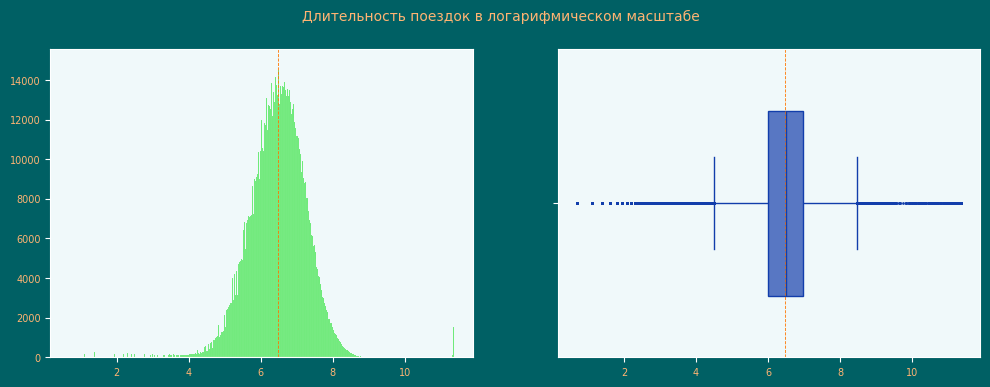

----------------------------------------
 P-value 0.0 меньше статистического уровня значимости 0.05. Распределение целевого признака не является нормальным
----------------------------------------


In [19]:
# Диаграммы
fig, axs = plt.subplots(1, 2, figsize=(12,4))
#fig.set_facecolor('#1D7074')
fig.suptitle('Длительность поездок в логарифмическом масштабе')
hp = sns.histplot(taxi_data, x='trip_duration_log', ax=axs[0], color=cmap[0])
hp.set(xlabel=None, ylabel=None)
axs[0].axvline(x=taxi_data['trip_duration_log'].mean(), color=cmap_lines[-1], linestyle='--')
bp = sns.boxplot(taxi_data, x='trip_duration_log', ax=axs[1], 
                 color=cmap[1], linecolor=cmap_lines[1], width=0.6, fliersize = 1)
bp.set(xlabel=None, ylabel=None)
axs[1].axvline(x=taxi_data['trip_duration_log'].mean(), color=cmap_lines[-1], linestyle='--')
plt.show();

# Тест Д'Агостино, проверка на нормальность
h0 = 'Распределение целевого признака является нормальным'
h1 = 'Распределение целевого признака не является нормальным'
alpha = 0.05 # Стат уровень значимости
res = stats.normaltest(taxi_data['trip_duration_log']) # Тест
print('-'*40)
# Оценка результатов теста
if res.pvalue < alpha:
    print(f' P-value {res.pvalue} меньше статистического уровня значимости {alpha}.', h1)
else:
    print(f' P-value {res.pvalue} выше статистического уровня значимости {alpha}.', h0)
print('-'*40)

> *Судя по графикам, распределение похоже на нормальное, медианные и средние значения близки друг к другу, но по критерию Д'Агостина выборка не распределена нормально.*

#### Гистограмма распределения длительности поездки в логарифмическом масштабе в зависимости от таксопарка.

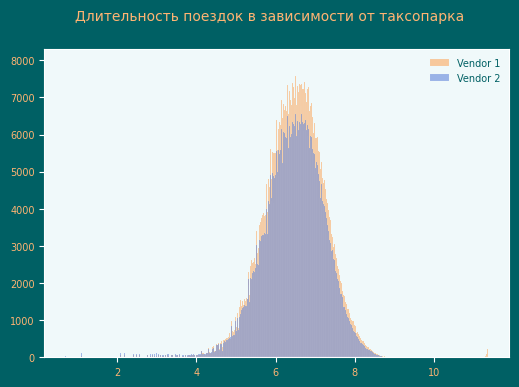

In [20]:
fig = plt.figure(figsize=(6,4))
fig.suptitle('Длительность поездок в зависимости от таксопарка')
hp = sns.histplot(taxi_data, x='trip_duration_log', hue='vendor_id', palette=cmap[1:3])
hp.legend(title='', labels=['Vendor 1', 'Vendor 2'])
hp.set(xlabel=None, ylabel=None)
plt.show();

> *Распределение длительноси поездок у обоих вендоров не имеет больших различий.*

#### Распределение длительности поездки в логарифмическом масштабе в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

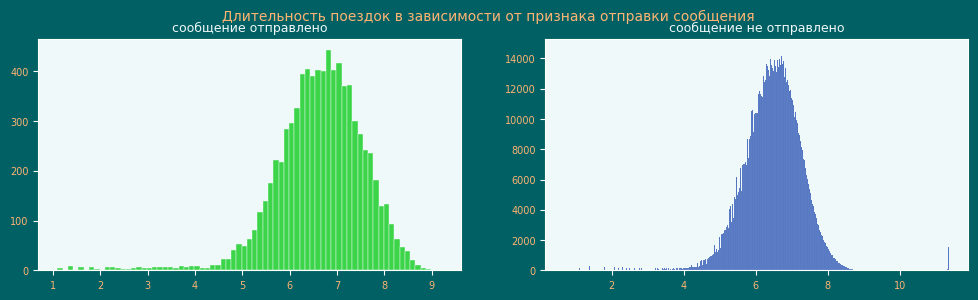

In [21]:
fig, axs = plt.subplots(1,2,figsize=(12,3))
fig.suptitle('Длительность поездок в зависимости от признака отправки сообщения')
hpY = sns.histplot(taxi_data[taxi_data['store_and_fwd_flag'] == 'Y'], x='trip_duration_log', color=cmap_lines[0], ax=axs[0])
hpY.set(xlabel=None, ylabel=None, title='сообщение отправлено')
hpN = sns.histplot(taxi_data[taxi_data['store_and_fwd_flag'] == 'N'], x='trip_duration_log', color=cmap_lines[1], ax=axs[1])
hpN.set(xlabel=None, ylabel=None, title='сообщение не отправлено')

plt.show();

> *Число поездок, при которых сообщение не было отправлено, сильно превышает число поездок, подтвержденных сообщением. Распределение с подтверждением смещено в сторону более высокой длительности поездки.*

#### Визуализация распределения количества поездок в зависимости от часа дня и зависимости медианной длительности поездки от часа дня.

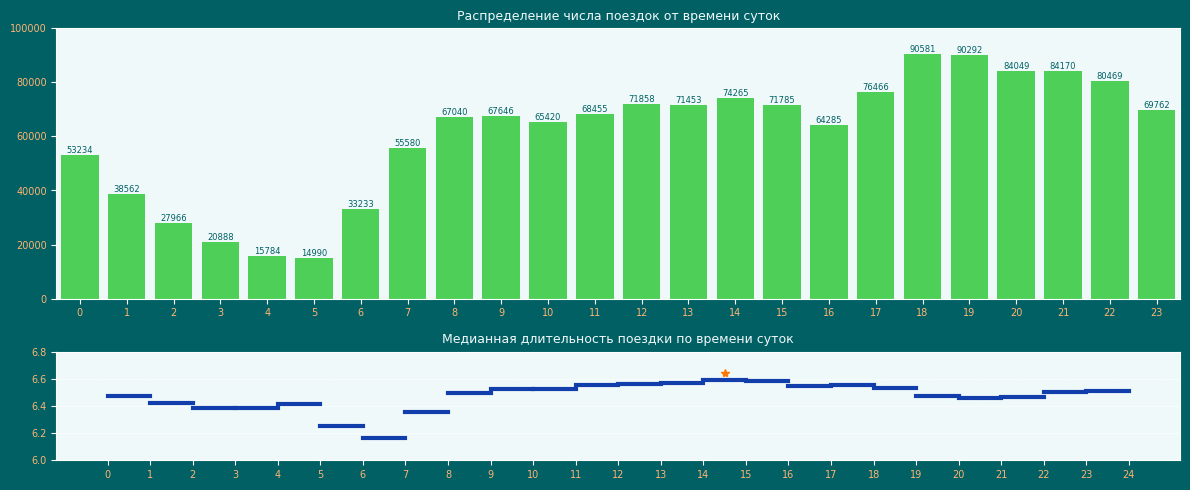

In [22]:
# Данные о числе поездок по времени суток
hours = taxi_data['pickup_hour'].value_counts().sort_index().index.to_numpy()
orders_by_hour = taxi_data['pickup_hour'].value_counts().sort_index().to_numpy()

# Диаграмма распределение количества поездок
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(3,1,(1,2))
bp1 = sns.barplot(y=orders_by_hour, x=hours, color=cmap[0], ax=ax1)
bp1.set(xlabel=None, ylabel=None, title='Распределение числа поездок от времени суток')
bp1.bar_label(bp1.containers[0], fontsize=6, color='#006064')
bp1.set_ylim(ymin=0, ymax=100000)

# Данные о медианной длительности поездок по времени суток
median = taxi_data.groupby('pickup_hour')['trip_duration_log'].median().to_numpy()
max_median = np.where(median == max(median))[0][0]

# Диаграмма зависимости медианной длительности поездки от часа дня
ax2 = fig.add_subplot(3,1,3)
for i in range(24):
    sns.lineplot(x=[i, i+1], y=median[i], color=cmap_lines[1], linewidth=3, ax=ax2)
ax2.set(xlabel=None, ylabel=None, xticks=list(range(25)), title='Медианная длительность поездки по времени суток')
ax2.grid(axis='y', linewidth=0.5, linestyle='--', color='w')
ax2.set_ylim(ymin=6, ymax=6.8)
ax2.plot(max_median+0.5, median[max_median]+0.05, '*', color=cmap_lines[3])
fig.tight_layout()
plt.show();


> * *Наибольшее число поездок на такси совершается с 18 до 20 часов.*
> * *Максимальную медианную длительность имеют поездки, совершаемые с 14 до 15 часов дня.* 

#### Визуализация распределения количества поездок в зависимости от дня недели и зависимости медианной длительности поездки от дня недели

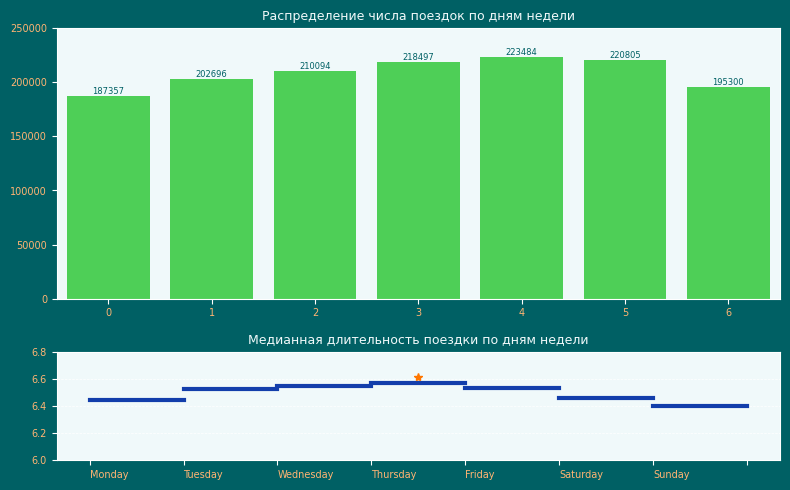

In [23]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Данные о числе поездок по дням недели 
days = taxi_data['pickup_day_of_week'].value_counts().sort_index().index.to_numpy()
orders_by_day = taxi_data['pickup_day_of_week'].value_counts().sort_index().to_numpy()

# Диаграмма распределение количества поездок
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(3,1,(1,2))
bp1 = sns.barplot(y=orders_by_day, x=days, color=cmap[0], ax=ax1)
bp1.set(xlabel=None, ylabel=None, title='Распределение числа поездок по дням недели')
bp1.bar_label(bp1.containers[0], fontsize=6, color='#006064')
bp1.set_ylim(ymin=0, ymax=250000)

# Данные о медианной длительности поездок по дням недели
median = taxi_data.groupby('pickup_day_of_week')['trip_duration_log'].median().to_numpy()
max_median = np.where(median == max(median))[0][0]

# Диаграмма зависимости медианной длительности поездки от часа дня
ax2 = fig.add_subplot(3,1,3)
for i in range(7):
    sns.lineplot(x=[i, i+1], y=median[i], color=cmap_lines[1], linewidth=3, ax=ax2)
ax2.set(xlabel=None, ylabel=None, xticks=list(range(25)), title='Медианная длительность поездки по дням недели')
ax2.grid(axis='y', linewidth=0.5, linestyle='--', color='w')
ax2.set_ylim(ymin=6, ymax=6.8)
ax2.plot(max_median+0.5, median[max_median]+0.05, '*', color=cmap_lines[3])
ax2.set_xticklabels(weekdays+['']*18, horizontalalignment='left')
fig.tight_layout()
plt.show();


> * *Наибольшее число поездок на такси в Нью-Йорке совершается в пятницу.*
> * *Наименьшая медианная длительность поездки - в воскресенье.*

##### 3.6. Тепловая карта распределения медианной длительности поездки по дням недели и времени суток

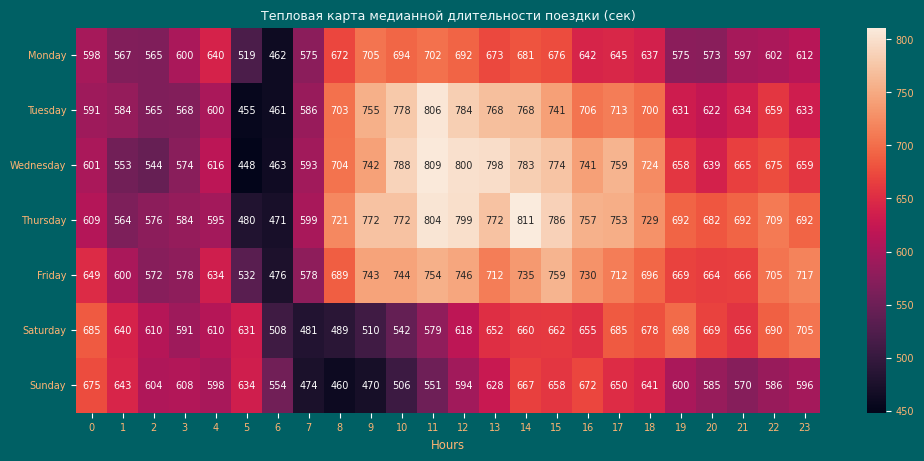

In [24]:
trip_duration_pivot = pd.pivot_table(taxi_data, 
                                    index='pickup_day_of_week', 
                                    columns='pickup_hour', 
                                    values='trip_duration',
                                    aggfunc='median')

fig = plt.figure(figsize=(12,5))
ax = sns.heatmap(trip_duration_pivot, annot=True, fmt='.0f', annot_kws={'size': 7})
ax.set(xlabel='Hours', ylabel=None, title='Тепловая карта медианной длительности поездки (сек)')
ax.set_yticklabels(labels=weekdays, rotation='horizontal')
plt.show();

> * *Наибольшую медианную длительность имеют поездки, совершаемые со вторника по пятницу примерно с 11 до 15 часов.*
> * *Наименьшую медианную длительность имеют поездки, совершаемые с понедельника по пятницу между 5 и 6 часами утра.*

##### 3.7. Диаграммы рассеяния географического расположения точек начала поездок и географического расположения точек завершения поездок.  


C:\Users\NOTIK_NEW\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\NOTIK_NEW\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


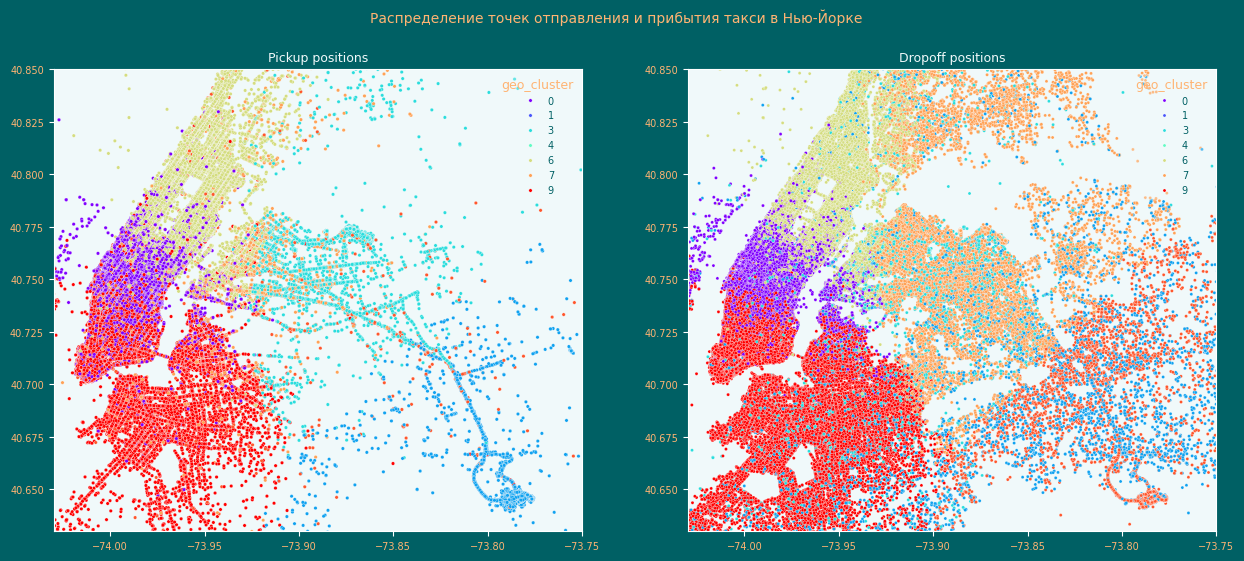

In [25]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Pickup position scatterplot
fig, ax = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Распределение точек отправления и прибытия такси в Нью-Йорке')
sns.scatterplot(taxi_data, x='pickup_longitude', y='pickup_latitude', s=6, 
                hue='geo_cluster', palette='rainbow', ax=ax[0])
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
ax[0].set(xlabel=None, ylabel=None, title='Pickup positions')
sns.scatterplot(taxi_data, x='dropoff_longitude', y='dropoff_latitude', s=5, 
                hue='geo_cluster', palette='rainbow', ax=ax[1])
ax[1].set_xlim(city_long_border)
ax[1].set_ylim(city_lat_border)
ax[1].set(xlabel=None, ylabel=None, title='Dropoff positions');

> * *Количество точек прибытия в Нью-Йорке превышает число точек посадки.*
> * *2-й и 5-й географические кластеры находятся за пределами Нью-Йорка.*
> * *Наиболее активны по заказу такси и прибытию такси районы Манхеттен, Бруклин и Международный аэропорт Кеннеди.*

### 4. Отбор и преобразование признаков

In [26]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [27]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


##### 4.1. Удаление избыточных признаков
Удалим избыточный признак 'id', уникальный для каждой записи и признаки data-leak: 'dropoff_datetime', 'total_travel_time'.

In [28]:
drop_columns = ['id','dropoff_datetime']
train_data = train_data.drop(columns=drop_columns, axis=1)
print(f'Shape of data: {train_data.shape}')

Shape of data: (1458233, 25)


Избавимся от признаков, из которых извлекли всю информацию

In [29]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


##### 4.2. Кодировка признаков vendor_id и store_and_fwd_flag.
* vendor_id равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.
* store_and_fwd_flag равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

In [30]:
# кодировка признака vendor_id
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
# кодировка признака store_and_fwd_flag
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# проверка
print(f"Среднее по признаку 'vendor_id': {train_data['vendor_id'].mean():.2f}")
print(f"Среднее по признаку 'store_and_fwd_flag': {train_data['store_and_fwd_flag'].mean():.3f}")

Среднее по признаку 'vendor_id': 0.53
Среднее по признаку 'store_and_fwd_flag': 0.006


##### 4.3. One-hot кодирование признаков pickup_day_of_week, geo_cluster и events
* Метод OneHotEncoding библиотеки sklearn handle_unknown = 'ignore', удаляем первый признак.
* Добавляем полученные бинарные столбцы вместо закодированных признаков. 


In [31]:
# Кодируем признаки
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')
res = encoder.fit_transform(train_data[columns_to_change]).toarray()
# Создаем таблицу
data_onehot = pd.DataFrame(res, columns=encoder.get_feature_names_out())

print(f'Полученное число бинарных признаков: {data_onehot.shape[1]}')

Полученное число бинарных признаков: 18


In [32]:
# Добавляем полученные признаки в таблицу данных
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Делим таблицу на целевой признак и таблицу факторов.

In [33]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1) # Фактор-признаки
y = train_data['trip_duration'] # целевой признак
y_log = train_data['trip_duration_log'] # целевой признак в логарифмическом формате

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [34]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

##### 4.4. Отбор 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе.

In [35]:
# Отбор 25 наиболее значимых признаков для модели регрессии
selector = feature_selection.SelectKBest(score_func = feature_selection.f_regression, k=25) 
selector.fit(X_train, y_train_log)
best_features = selector.get_feature_names_out()
print('Список наиболее значимых признаков:\n', best_features)

# Удаление менее значимых признаков
X_train = X_train[best_features]
X_valid = X_valid[best_features]

Список наиболее значимых признаков:
 ['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_1'
 'pickup_day_of_week_2' 'pickup_day_of_week_3' 'pickup_day_of_week_4'
 'pickup_day_of_week_5' 'pickup_day_of_week_6' 'geo_cluster_2'
 'geo_cluster_3' 'geo_cluster_6' 'geo_cluster_7' 'geo_cluster_8']


##### 4.5. Нормализация признаков MinMaxScaler

In [36]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print(f'Среднее значение по первому предиктору: {X_valid_scaled[:,0].mean():.2f}')

Среднее значение по первому предиктору: 0.54


### 5. Решение задачи регрессии: линейная регрессия и деревья решений

Качество моделей будет оцениваться метрикой RMSLE (Root Mean Squared Log Error)

Создадим таблицу метрик для сравнения моделей

In [37]:
metrics_db = pd.DataFrame(columns=['Model', 'RSMLE_train', 'RSMLE_valid'])

##### 5.1. Модель линейной регрессии

In [38]:
model = linear_model.LinearRegression() # Задаем модель
model.fit(X_train_scaled, y_train_log) # Обучаем модель
# Выполняем предсказание
y_train_log_predict = model.predict(X_train_scaled)
y_valid_log_predict = model.predict(X_valid_scaled)
# Считаем метрику
metrics_db = pd.concat([metrics_db,
                pd.DataFrame({'Model': ['linear regression'],
                'RSMLE_train': [metrics.root_mean_squared_error(y_train_log, y_train_log_predict)],
                'RSMLE_valid': [metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict)]})])

print(f'RSMLE на обучающей выборке: {metrics.root_mean_squared_error(y_train_log, y_train_log_predict):.2f}')
print(f'RSMLE на валидационной выборке: {metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict):.2f}')


RSMLE на обучающей выборке: 0.54
RSMLE на валидационной выборке: 0.54


C:\Users\NOTIK_NEW\AppData\Local\Temp\ipykernel_11336\84613544.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_db = pd.concat([metrics_db,


##### 5.2. Модель полиномиальной регрессии 2-ой степени

In [39]:
# Создаем полиномиальные признаки
polynom = preprocessing.PolynomialFeatures(include_bias=False)
X_train_poly = polynom.fit_transform(X_train_scaled)
X_valid_poly = polynom.transform(X_valid_scaled)

In [40]:
# Модель линейной регрессии
model = linear_model.LinearRegression()# Создаем модель
model.fit(X_train_poly, y_train_log) # Обучаем модель
y_train_log_predict = model.predict(X_train_poly) # Предсказание на обучающей выборке
y_valid_log_predict = model.predict(X_valid_poly) # Предсказание на валидационной выборке

# Считаем метрику
metrics_db = pd.concat([metrics_db,
                pd.DataFrame({'Model': ['polinomial regression'],
                'RSMLE_train': [metrics.root_mean_squared_error(y_train_log, y_train_log_predict)],
                'RSMLE_valid': [metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict)]})])

print(f'RSMLE на обучающей выборке: {metrics.root_mean_squared_error(y_train_log, y_train_log_predict):.2f}')
print(f'RSMLE на валидационной выборке: {metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict):.2f}')

RSMLE на обучающей выборке: 0.47
RSMLE на валидационной выборке: 0.69


##### 5.3. Модель полиномиальной регрессии 2-ой степени с L2-регуляризацией

In [41]:
# Модель Лассо
l2_model = linear_model.Ridge(alpha=2, solver='sag', max_iter=10000) # Строим модель
l2_model.fit(X_train_poly, y_train_log) # Обучаем модель
y_train_log_predict = l2_model.predict(X_train_poly) # Предсказание на обучающей выборке
y_valid_log_predict = l2_model.predict(X_valid_poly) # Предсказание на валидационной выборке

# Считаем метрику
metrics_db = pd.concat([metrics_db,
                pd.DataFrame({'Model': ['ridge regression'],
                'RSMLE_train': [metrics.root_mean_squared_error(y_train_log, y_train_log_predict)],
                'RSMLE_valid': [metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict)]})])

print(f'RSMLE на обучающей выборке: {metrics.root_mean_squared_error(y_train_log, y_train_log_predict):.2f}')
print(f'RSMLE на валидационной выборке: {metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict):.2f}')

RSMLE на обучающей выборке: 0.48
RSMLE на валидационной выборке: 0.48


##### 5.4. Модель дерева решений 

In [42]:
tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train_scaled, y_train_log) # Обучаем модель
y_train_log_predict = tree_model.predict(X_train_scaled) # Предсказание на обучающей выборке
y_valid_log_predict = tree_model.predict(X_valid_scaled) # Предсказание на валидационной выборке

# Считаем метрику
# Считаем метрику
metrics_db = pd.concat([metrics_db,
                pd.DataFrame({'Model': ['decision tree'],
                'RSMLE_train': [metrics.root_mean_squared_error(y_train_log, y_train_log_predict)],
                'RSMLE_valid': [metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict)]})])
print(f'RSMLE на обучающей выборке: {metrics.root_mean_squared_error(y_train_log, y_train_log_predict):.2f}')
print(f'RSMLE на валидационной выборке: {metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict):.2f}')

RSMLE на обучающей выборке: 0.00
RSMLE на валидационной выборке: 0.56


In [43]:
tree_model.get_depth()

61

##### 5.5. Подбор оптимальной глубины дерева


Оптимальная глубина дерева: 12
RSMLE на обучающей выборке: 0.41
RSMLE на валидационной выборке: 0.43


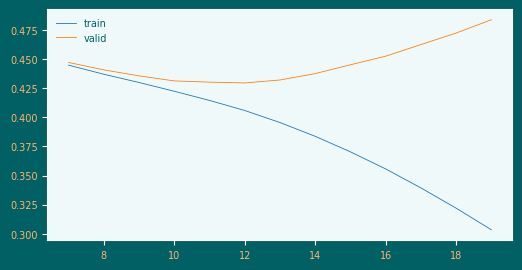

In [44]:
train_metrics = []
valid_metrics = []
for max_depth in range(7,20):
    tree_model = tree.DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree_model.fit(X_train_scaled, y_train_log) # Обучаем модель
    y_train_log_predict = tree_model.predict(X_train_scaled) # Предсказание на обучающей выборке
    y_valid_log_predict = tree_model.predict(X_valid_scaled) # Предсказание на валидационной выборке
    
    # Считаем метрику
    train_metrics.append(metrics.root_mean_squared_error(y_train_log, y_train_log_predict))
    valid_metrics.append(metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict))
    
   
# График метрик    
x = list(range(7,20))
fig = plt.figure(figsize=(6,3))
plt.plot(x, train_metrics, label='train')
plt.plot(x, valid_metrics, label='valid')
plt.legend()

print(f'Оптимальная глубина дерева: 12')

# Модель дерева с оптимальной глубиной (12)
tree_model = tree.DecisionTreeRegressor(max_depth=12, random_state=42)
tree_model.fit(X_train_scaled, y_train_log) # Обучаем модель
y_train_log_predict = tree_model.predict(X_train_scaled) # Предсказание на обучающей выборке
y_valid_log_predict = tree_model.predict(X_valid_scaled) # Предсказание на валидационной выборке

# Считаем метрику
metrics_db = pd.concat([metrics_db,
                pd.DataFrame({'Model': ['decision tree regressor 12'],
                'RSMLE_train': [metrics.root_mean_squared_error(y_train_log, y_train_log_predict)],
                'RSMLE_valid': [metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict)]})])
print(f'RSMLE на обучающей выборке: {metrics.root_mean_squared_error(y_train_log, y_train_log_predict):.2f}')
print(f'RSMLE на валидационной выборке: {metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict):.2f}')

### 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

##### 6.1. Модель случайного леса

In [45]:
%%time
# Создаем модель
rf_model = ensemble.RandomForestRegressor(n_estimators=200,
                                            max_depth=12,
                                            criterion='squared_error',
                                            min_samples_split=20,
                                            random_state=42)
rf_model.fit(X_train_scaled, y_train_log) # Обучаем модель
y_train_log_predict = rf_model.predict(X_train_scaled) # Предсказание на обучающей выборке
y_valid_log_predict = rf_model.predict(X_valid_scaled) # Предсказание на валидационной выборке

# Считаем метрику
# Считаем метрику
metrics_db = pd.concat([metrics_db,
                pd.DataFrame({'Model': ['random forest regressor'],
                'RSMLE_train': [metrics.root_mean_squared_error(y_train_log, y_train_log_predict)],
                'RSMLE_valid': [metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict)]})])
print(f'RSMLE на обучающей выборке: {metrics.root_mean_squared_error(y_train_log, y_train_log_predict):.2f}')
print(f'RSMLE на валидационной выборке: {metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict):.2f}')

RSMLE на обучающей выборке: 0.40
RSMLE на валидационной выборке: 0.41
CPU times: total: 48min 15s
Wall time: 48min 33s


##### 6.2. Модель градиентного бустинга над деревьями решений

In [46]:
%%time
# Создаем модель
gb_model = ensemble.GradientBoostingRegressor(learning_rate=0.5,
                                                n_estimators=100, # Число деревьев в ансамбле
                                                max_depth=10,  # Глубина дерева
                                                min_samples_leaf=3,
                                                min_samples_split=30,
                                                random_state=42)
gb_model.fit(X_train_scaled, y_train_log) # Обучаем модель
y_train_log_predict = gb_model.predict(X_train_scaled) # Предсказание на обучающей выборке
y_valid_log_predict = gb_model.predict(X_valid_scaled) # Предсказание на валидационной выборке

# Считаем метрику
metrics_db = pd.concat([metrics_db,
                pd.DataFrame({'Model': ['gradient boosting regressor'],
                'RSMLE_train': [metrics.root_mean_squared_error(y_train_log, y_train_log_predict)],
                'RSMLE_valid': [metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict)]})])
print(f'RSMLE на обучающей выборке: {metrics.root_mean_squared_error(y_train_log, y_train_log_predict):.2f}')
print(f'RSMLE на валидационной выборке: {metrics.root_mean_squared_error(y_valid_log, y_valid_log_predict):.2f}')

RSMLE на обучающей выборке: 0.32
RSMLE на валидационной выборке: 0.40
CPU times: total: 30min 30s
Wall time: 30min 51s


In [47]:
gb_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.5,
 'loss': 'squared_error',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### 6.3 Сравнение результатов моделей

In [48]:
for i in range(metrics_db.shape[0]):
    print(metrics_db.iloc[i]['Model'].ljust(30), end='') 
    print(f'train RSMLE = {metrics_db.iloc[i]['RSMLE_train']:.2f}', end=',     ')
    print(f'valid RSLME = {metrics_db.iloc[i]['RSMLE_valid']:.2f}')
    

linear regression             train RSMLE = 0.54,     valid RSLME = 0.54
polinomial regression         train RSMLE = 0.47,     valid RSLME = 0.69
ridge regression              train RSMLE = 0.48,     valid RSLME = 0.48
decision tree                 train RSMLE = 0.00,     valid RSLME = 0.56
decision tree regressor 12    train RSMLE = 0.41,     valid RSLME = 0.43
random forest regressor       train RSMLE = 0.40,     valid RSLME = 0.41
gradient boosting regressor   train RSMLE = 0.32,     valid RSLME = 0.40


> *Наилучший результат метрики RSMLE на валидационной выборке показаала модель градиентного бустинга*

##### 6.4. Диаграмма коэффициентов значимости факторов

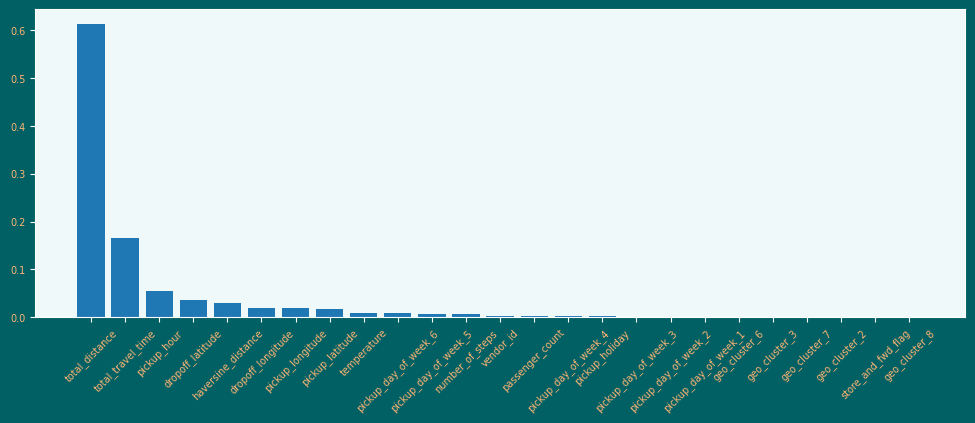

In [49]:
factor_importances = pd.DataFrame({'factors': list(X_train.columns),
                                   'importances': gb_model.feature_importances_})
factor_importances.sort_values('importances', ascending=False, inplace=True)

fig = plt.figure(figsize=(12,4))
plt.bar(factor_importances['factors'], factor_importances['importances'])
plt.xticks(rotation=45);

> *Наиболее значимыми факторами оказались расстояние, длительность и время поездки ('total_distance', 'total_travel_time', 'pickup_time')*

##### 6.5. Медианная абсолютная ошибка на валидационной выборке

In [50]:
y_valid = np.exp(np.array(y_valid_log.values))-1
y_valid_predict = np.exp(y_valid_log_predict)
MeAE = metrics.median_absolute_error(y_valid, y_valid_predict)
print(f'Медианная абсолютная ошибка на валидационной выборке равна {MeAE / 60:.1f}')

Медианная абсолютная ошибка на валидационной выборке равна 1.8


##### 6.6. Предсказание для отложенного тестового набора данных

In [51]:
test_data = pd.read_csv("Data/test.csv")
test_id = test_data['id'] # Отдельное сохранение столбца индексов
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [52]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


Преобразование тестового набора данных

In [54]:
osrm_data_test = pd.read_csv("Data/osrm_data_test.csv")
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot =encoder.transform(test_data[columns_to_change]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Выполняем предсказание для тестовой выборки

In [55]:
# Предсказание
y_test_log_predict = gb_model.predict(X_test_scaled)

# Преобразуем предсказание из логарифмического масштаба в истинный
y_test_predict = np.exp(y_test_log_predict) - 1

# Выгружаем результаты в файл для загрузки на Kagge
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### XGBoost

In [56]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(data=X_train_scaled, label=y_train_log, feature_names=list(best_features))
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=list(best_features))
dtest = xgb.DMatrix(X_test_scaled, feature_names=list(best_features))

In [57]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.08, 'colsample_bytree': 0.9, 
            'max_depth': 8, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.74875	valid-rmse:0.75075
[10]	train-rmse:0.50790	valid-rmse:0.51106
[20]	train-rmse:0.43950	valid-rmse:0.44361
[30]	train-rmse:0.41840	valid-rmse:0.42321
[40]	train-rmse:0.40928	valid-rmse:0.41473
[50]	train-rmse:0.40332	valid-rmse:0.40951
[60]	train-rmse:0.39923	valid-rmse:0.40613
[70]	train-rmse:0.39586	valid-rmse:0.40364
[80]	train-rmse:0.39288	valid-rmse:0.40147
[90]	train-rmse:0.39029	valid-rmse:0.39957
[100]	train-rmse:0.38816	valid-rmse:0.39811
[110]	train-rmse:0.38638	valid-rmse:0.39705
[120]	train-rmse:0.38466	valid-rmse:0.39599
[130]	train-rmse:0.38325	valid-rmse:0.39522
[140]	train-rmse:0.38199	valid-rmse:0.39454
[150]	train-rmse:0.38064	valid-rmse:0.39366
[160]	train-rmse:0.37926	valid-rmse:0.39289
[170]	train-rmse:0.37824	valid-rmse:0.39247
[180]	train-rmse:0.37709	valid-rmse:0.39184
[190]	train-rmse:0.37625	valid-rmse:0.39156
[200]	train-rmse:0.37534	valid-rmse:0.39107
[210]	train-rmse:0.37434	valid-rmse:0.39078
[220]	train-rmse:0.37348	valid-rmse:0.39053

In [58]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.38880


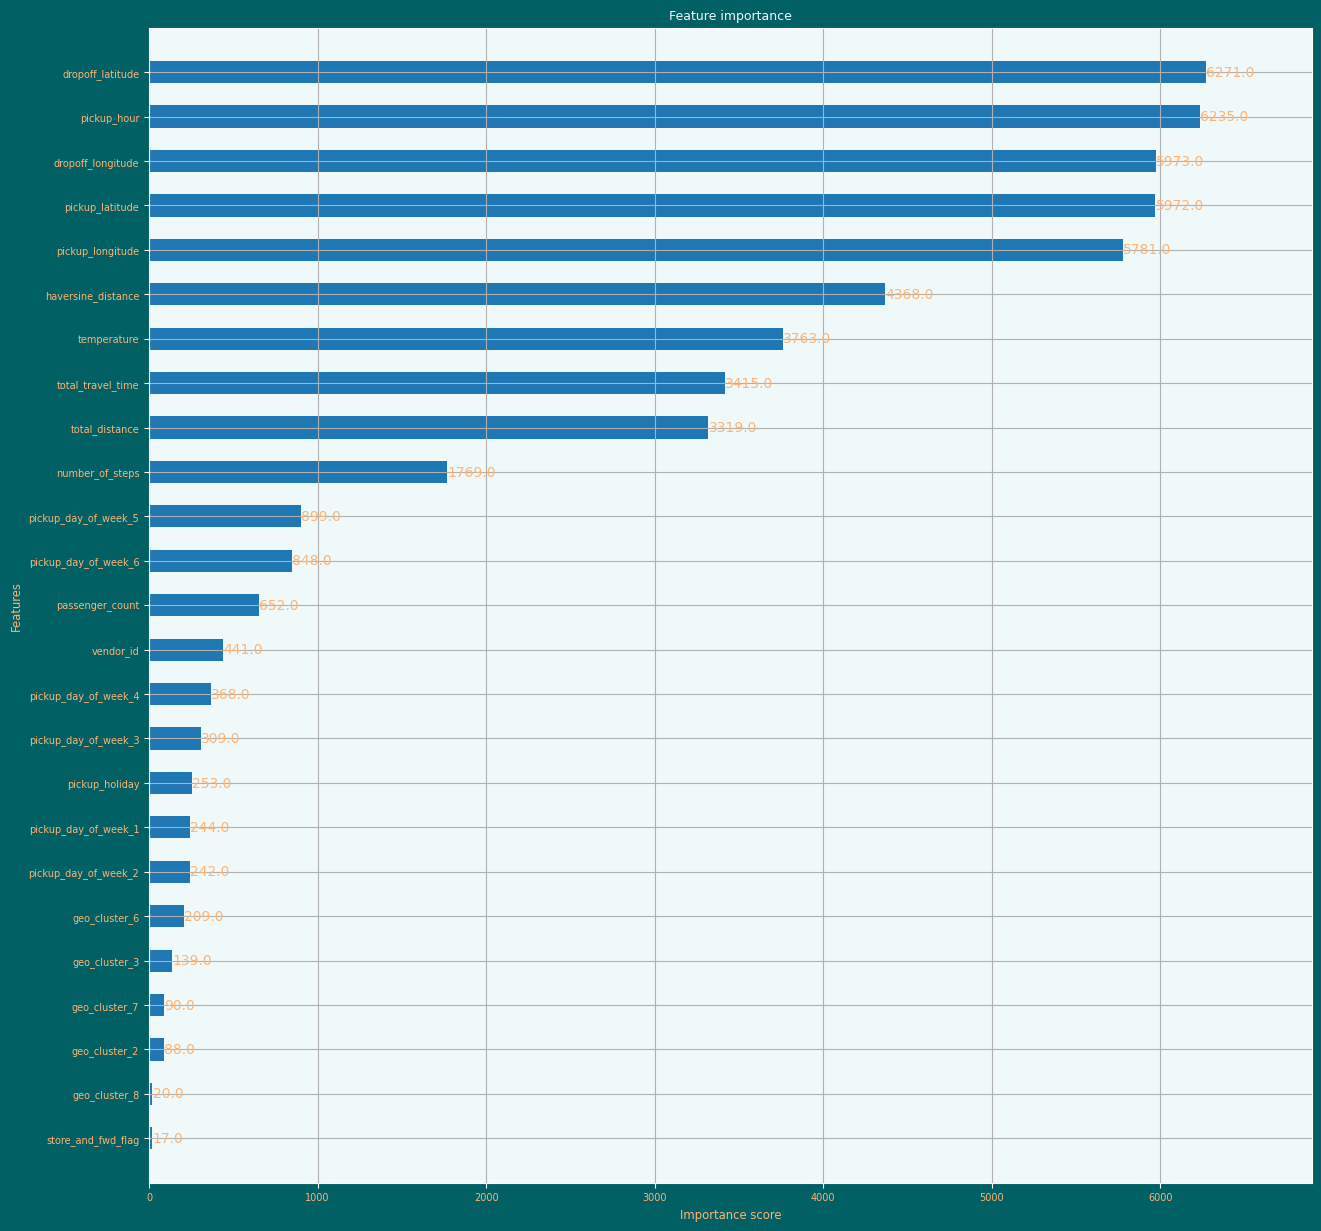

In [59]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5);